<a href="https://colab.research.google.com/github/kaitlynrv/sbux_repo/blob/main/SBUX_random_buy_sell_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#import library for yahoo finance
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

In [18]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None

    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))

            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]

        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit(maxiter=200)

                #get forecast
                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1



        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order)
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):


            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)

    if verbose:
        print('Total Amount: $%s'%round(amt,2))

    #graph
    if plot:

        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims),
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()

    return amt

#Read Data

In [12]:
#obtain SBUX stock data from Yahoo Finance
tickerSymbol = 'SBUX'
sbux = yf.Ticker(tickerSymbol)


In [9]:
#get all data from beginning of 2023 to present
prices = sbux.history(start='2023-01-01', end='2023-11-01').Close
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Prices')

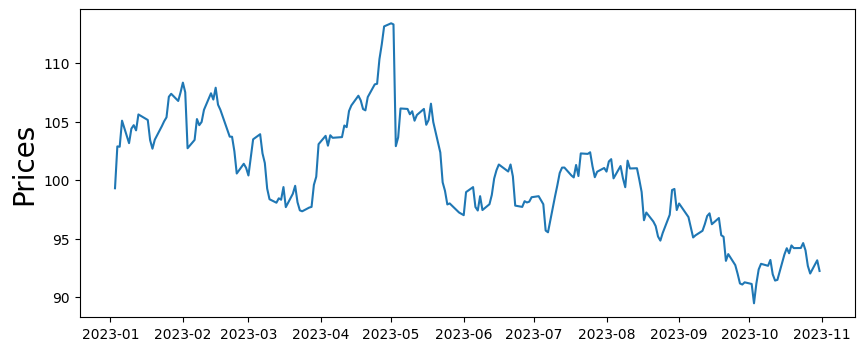

In [13]:
#plot price of SBUX event day in time period defined above
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

Text(0, 0.5, 'Return')

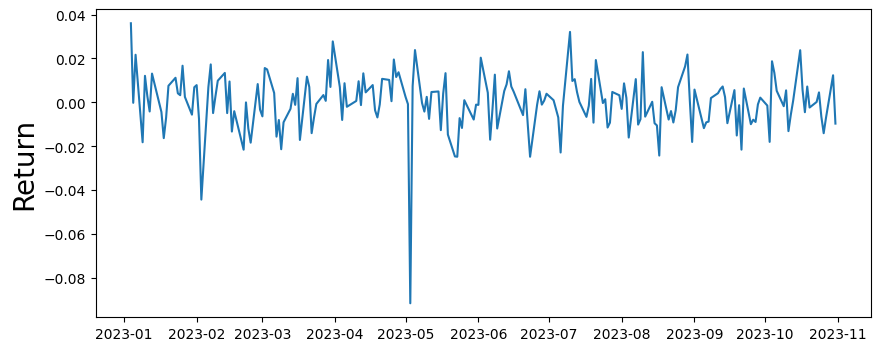

In [14]:
#Plot the percent change in stock price day-to-day
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

Note a significant negative change in stock price at the beginning of May, 2023. On May, 7 Starbucks illegally fired Union Workers, this may be a reason for the decrease on return

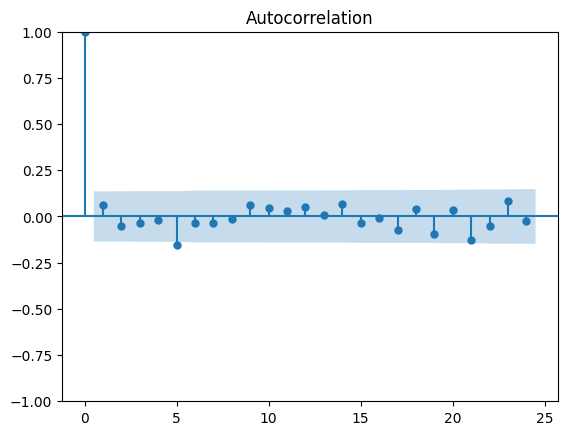

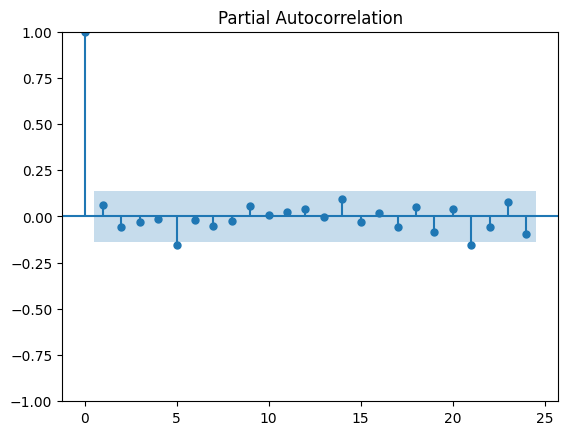

In [15]:
#Build ACF and PACF of the returns
plot_acf(returns)
plt.show()

plot_pacf(returns)
plt.show()

Note that there are spikes at 5 days. The reason for this is likely since the stock market is closed on weekends (after 5 week days)


#Building Baseline Model

100%|██████████| 194/194 [00:00<00:00, 7821.06it/s]


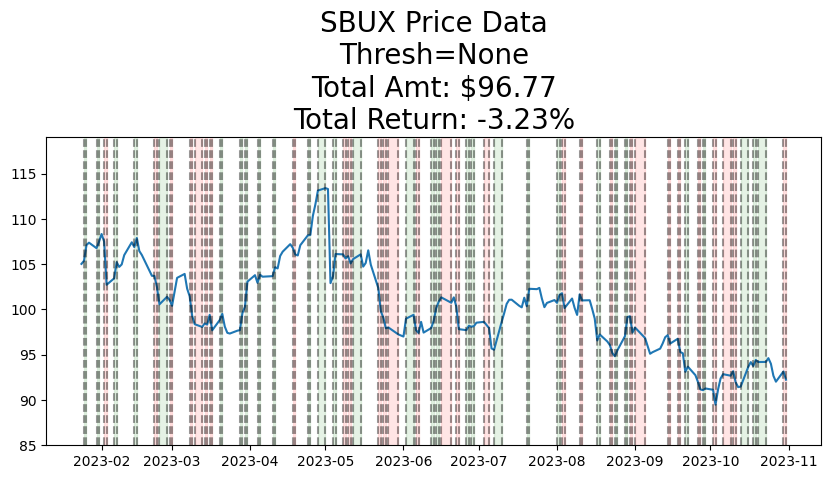

96.77403577640486

In [21]:
#Create graphic to show where stock price goes up or down after buying and selling
run_simulation(returns, prices, 100, 0.5, None, verbose=False)

The fields above shows us when random buying and selling subsequently occurs. When the field is red, the random decision to buy was made and the stock was sold the next day for a lower price. Green means it was sold at a higher price the following day.

Starting with 100 USD, we ended with 96.77 USD, with a decrease in returns at about -3%.

The model above is one possible outcome. You can run multiple times to visualize different scenerios

In [22]:
#run the above 1000 time to get an average
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]


100%|██████████| 194/194 [00:00<00:00, 6948.18it/s]


<ipython-input-25-da3a5e21c284>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_amts)


Text(0.5, 1.0, 'Avg: $95.98\nSD: $7.7')

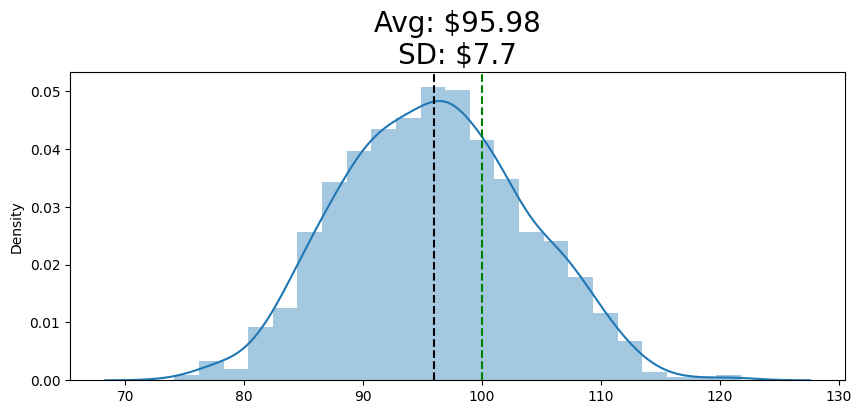

In [25]:
#Plot a histogram of all return values and print the mean and standard deviation on returns
plt.figure(figsize=(10,4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

On average, the returns were lower than the initial investment of 100 USD. So by randomly buying and selling, you would most likely be losing money

#Another Model

This model will now only buy if the last return was positive

100%|██████████| 194/194 [00:00<00:00, 10725.28it/s]


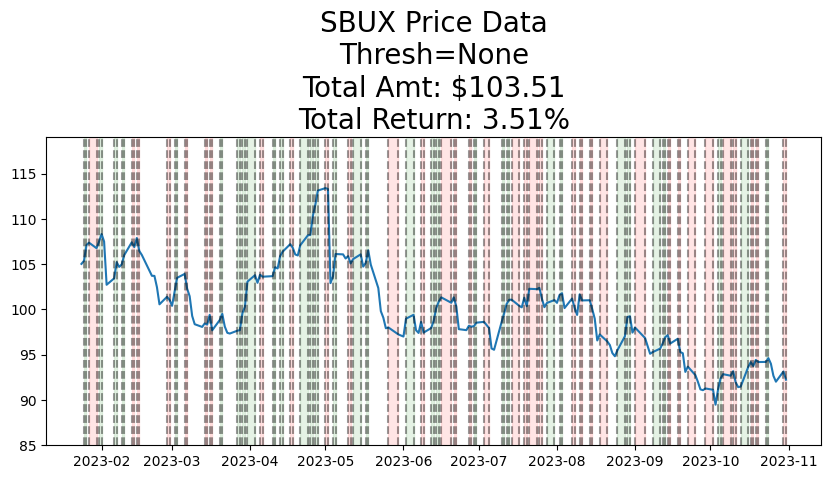

103.51335032544638

In [26]:
#run the model described above
run_simulation(returns, prices, 100, 'last', None, verbose=False)

The model above performs slightly better, now with a positive return of about 3%